# Antibody Classifier Analysis

## Introduction

This report will present final analysis on processed antibody data acquired from [OAS](https://opig.stats.ox.ac.uk/webapps/oas/dataunit?unit=Briney_2019/csv/SRR8283601_1_Heavy_Bulk.csv.gz) and the [Therapeutic Structural Antibody Database](https://opig.stats.ox.ac.uk/webapps/sabdab-sabpred/therasabdab/search/). The purpose of this project is to take raw antibody sequences and build an automated pipeline using Snakemake that builds and processes them with a protein language model to generate embeddings which will be used to train a stacked ensemble model classifier to predict the binding potential of a given antibody sequence.

### Biological Background and ML approach

When considering the results of this notebook there are two key biological considerations regarding how the data was chosen the reader must be aware of. First, Bulk antibody data pulled from OAS serves as a proxy for non-binding antibodies and the TheraSAbDab data serves as a proxy for binding antibodies. While this is acceptable for a machine learning project, it should be noted that a more robust approach suitable for therapeutic applications requires experimentally verified binding data. Second, in order to make the data manageable, only sequence data for the [variable heavy domain](https://www.ncbi.nlm.nih.gov/books/NBK27144) of a given antibody was used. [This is because the *majority* of binding variation in antibodies is determined by the variable heavy domain](https://pmc.ncbi.nlm.nih.gov/articles/PMC4941225).

The dataset for the non-binding proxy was pulled from a nature publication by [Briney et. al.](https://www.nature.com/articles/s41586-019-0879-y) the original study was focused on highlighting baseline commonalities in human antibodies despite the number of unique antibodies present approaching one trillion. Because the objective of the study was to analyse a wide range of antibody types, the data was determined to well suited to serve as a stand in for non-therapeutic binding antibodies.

The dataset serving as a proxy for binding sites with therapeutic value is from TheraSAbDab. It is carefully curated to contain only antibodies with binding sites known to have therapeutic use and provides the corresponding variable domain sequence.

data from both of these datasets were randomized and combined such that a 50/50 split of non-binding, and binding classes was obtained. The sequences in this data set was then fed into the 650 million parameter [esm2](https://github.com/facebookresearch/esm) model and mean-pooled sequence embeddings generated. It should be noted that an antibody specific model may produce better results than the broad protein language model chosen here given unique properties of antibodies.

This new dataset with embeddings will be used to train a stacked ensemble classifier from Random Forest, and Xgboost base learners. It should be noted that other properties such as melting point, colloidal stability, solubility, etc. would likely enhance the accuracy of the model but will not be included here.

## EDA

A brief exploration of the data performed here will confirm the previous processing steps were correctly performed. This includes checking for class imbalance, confirming the size of the dataset, and checking for any near identical embeddings resulting from clonal variants that were missed during the deduplication step during data processing.

In [1]:
import numpy as np
# load packages and data

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, RandomizedSearchCV 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

df = pd.read_csv("../data/embeds_df.csv")

In [2]:
df.head()

,sequence_id,sequence,class,em_000,em_001,em_002,em_003,em_004,em_005,em_006,...,em_470,em_471,em_472,em_473,em_474,em_475,em_476,em_477,em_478,em_479
0,oas_248,TGAAATCTTCGGAGACCCTGTCCCTCACCTGCACTGTCTCTGGTGG...,0,-0.190176,-0.155131,-0.109094,-0.027862,0.662152,0.201676,-0.046191,...,-0.060475,-0.077489,0.233516,0.109763,0.035420,0.220182,-0.212312,0.420229,0.095845,0.304392
1,thera_432,QAYLQQSGAELVRPGASVKMSCKASGYTFTSYNMHWVKQTPRQGLE...,1,-0.203596,-0.021637,0.138602,0.016943,0.136280,0.065213,-0.338449,...,0.097738,0.154735,0.180917,-0.156021,-0.074100,-0.141278,-0.179113,0.186787,-0.153930,-0.192463
2,thera_975,QVQLQQSGPELVKPGALVKISCKASGYTFTNYDIHWVKQRPGQGLE...,1,-0.093611,-0.064672,0.059400,0.024815,0.191268,0.040335,-0.300456,...,0.165173,0.088541,0.017032,-0.043517,-0.055917,-0.056035,-0.339277,0.237943,-0.167897,-0.221095
3,oas_12711,GGAATAGGCCTCAGTGAAGGTCTCCTGCAAGGCTTCTGGATACACC...,0,-0.198891,-0.137579,-0.121316,0.070521,0.642038,0.200676,-0.054097,...,-0.280824,-0.043928,0.310932,0.074602,0.093365,0.327380,-0.188139,0.382039,0.168869,0.311335
4,oas_13342,GTCTTCGGAGACCCTGTCCCTCACCTGCGCTGTCTATGGTGGGTCC...,0,-0.210705,-0.112799,-0.078429,0.107259,0.577013,0.201226,-0.090925,...,-0.257420,-0.071330,0.237538,0.079526,0.101699,0.275856,-0.215858,0.385863,0.133935,0.272946


The data correctly displays a 5x1283 matrix with 1280 columns representing the embeddings from the esm model, the associated sequence, id for the sequence, and its class. Now class imbalance must be assessed.

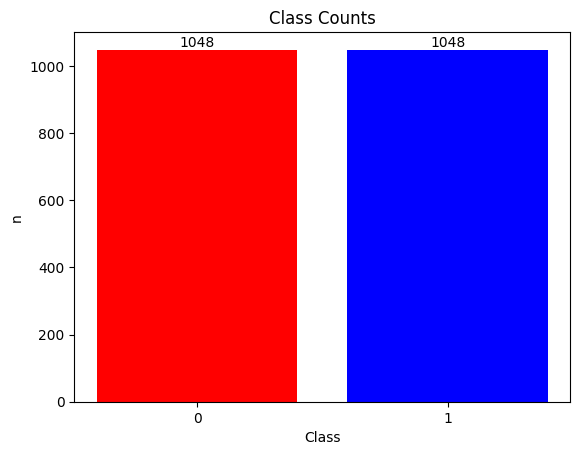

In [3]:
class_counts = df['class'].value_counts()

bar_plot = plt.bar(class_counts.index,class_counts.values, color=['r','b'])
plt.title('Class Counts')
plt.xlabel('Class')
plt.ylabel('n')
plt.xticks([0,1])
plt.bar_label(bar_plot, labels=class_counts.values)
plt.show()

The plot above shows that the dataset is balanced with 1133 observations of each class.

## Base Model Construction and Evaluation

Base models will be built using k-fold validation and key statistics such as AUC-ROC and F1 score compared.

### Splitting the Data

An initial 80/20 split of the data will be created

In [4]:
X, y = df.iloc[:, 3:], df['class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y)

### Random Forest

In [5]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

forest_preds = clf.predict(X_test)

clf.score(X_test, y_test)

1.0

### Xgboost tree

In [6]:
clf_boost = GradientBoostingClassifier().fit(X_train, y_train)
clf_boost.score(X_test, y_test)

1.0

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    classification_report,
    roc_auc_score
)
from sklearn.dummy import DummyClassifier

# Load your data
df = pd.read_csv("../data/embeds_df.csv")

# Identify embedding columns (assuming they start with 'em_')
embed_cols = [col for col in df.columns if col.startswith('em_')]
X = df[embed_cols].values
y = df['class'].values  # Replace with your actual target column

print("=" * 60)
print("DATASET DIAGNOSTICS")
print("=" * 60)

# 1. Basic info
print(f"\nTotal samples: {len(df)}")
print(f"Number of features: {len(embed_cols)}")
print(f"\nClass distribution:")
print(pd.Series(y).value_counts())
print(f"\nClass proportions:")
print(pd.Series(y).value_counts(normalize=True))

# 2. Check for duplicates
print(f"\n--- DUPLICATE CHECK ---")
print(f"Duplicate sequences: {df.duplicated(subset=['sequence']).sum()}")
print(f"Duplicate embeddings: {df[embed_cols].duplicated().sum()}")

# 3. Check embedding variance
print(f"\n--- EMBEDDING QUALITY CHECK ---")
print(f"Embedding mean: {X.mean():.4f}")
print(f"Embedding std: {X.std():.4f}")
print(f"Zero variance features: {(X.std(axis=0) == 0).sum()}")
print(f"Constant embeddings (all same): {(X.std(axis=0) < 1e-10).sum()}")

# 4. Check if embeddings are suspiciously separable
from scipy.spatial.distance import pdist, squareform
print(f"\n--- SEPARABILITY CHECK ---")
# Sample if dataset is large
sample_size = min(100, len(X))
X_sample = X[:sample_size]
y_sample = y[:sample_size]
dists = pdist(X_sample)
print(f"Min pairwise distance: {dists.min():.6f}")
print(f"Max pairwise distance: {dists.max():.6f}")
print(f"Mean pairwise distance: {dists.mean():.6f}")

# 5. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n--- TRAIN/TEST SPLIT ---")
print(f"Train size: {len(X_train)}")
print(f"Test size: {len(X_test)}")
print(f"Train class distribution: {np.bincount(y_train)}")
print(f"Test class distribution: {np.bincount(y_test)}")

# 6. Baseline - Dummy Classifier (predicts most frequent class)
print("\n" + "=" * 60)
print("BASELINE: DUMMY CLASSIFIER (Most Frequent)")
print("=" * 60)
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_dummy):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_dummy))

# 7. Simple Logistic Regression (no regularization)
print("\n" + "=" * 60)
print("LOGISTIC REGRESSION (C=1.0)")
print("=" * 60)
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)

print(f"Train Accuracy: {accuracy_score(y_train, lr.predict(X_train)):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

if len(np.unique(y)) == 2:
    print(f"\nROC-AUC: {roc_auc_score(y_test, y_prob_lr[:, 1]):.4f}")

# 8. Check if model is just memorizing
print("\n--- MEMORIZATION CHECK ---")
# Try with shuffled labels - should get ~50% if not memorizing
X_train_shuf, X_test_shuf, y_train_shuf, y_test_shuf = train_test_split(
    X, np.random.permutation(y), test_size=0.2, random_state=42
)
lr_shuf = LogisticRegression(max_iter=1000, random_state=42)
lr_shuf.fit(X_train_shuf, y_train_shuf)
print(f"Accuracy with SHUFFLED labels: {accuracy_score(y_test_shuf, lr_shuf.predict(X_test_shuf)):.4f}")
print("(Should be ~chance level if model is learning real patterns)")

# 9. Random Forest with limited depth
print("\n" + "=" * 60)
print("RANDOM FOREST (max_depth=3, n_estimators=10)")
print("=" * 60)
rf_simple = RandomForestClassifier(
    n_estimators=10, 
    max_depth=3, 
    random_state=42,
    min_samples_leaf=10  # Prevent overfitting
)
rf_simple.fit(X_train, y_train)
y_pred_rf = rf_simple.predict(X_test)

print(f"Train Accuracy: {accuracy_score(y_train, rf_simple.predict(X_train)):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

# 10. Feature importance check (top 10)
print("\n--- TOP 10 MOST IMPORTANT FEATURES ---")
importances = rf_simple.feature_importances_
top_idx = np.argsort(importances)[-10:][::-1]
for idx in top_idx:
    print(f"{embed_cols[idx]}: {importances[idx]:.4f}")

print("\n" + "=" * 60)
print("DIAGNOSIS SUMMARY")
print("=" * 60)
print("\nIf you see:")
print("1. Test accuracy = 1.0 but shuffled labels also high → Data leakage")
print("2. Test accuracy = 1.0 and train accuracy = 1.0 → Overfitting or leakage")
print("3. Many duplicate embeddings → Problem with embedding generation")
print("4. Train >> Test accuracy with simple model → Normal (some overfitting)")
print("5. Dummy classifier near perfect → Severe class imbalance issue")

DATASET DIAGNOSTICS

Total samples: 2096
Number of features: 480

Class distribution:
0    1048
1    1048
Name: count, dtype: int64

Class proportions:
0    0.5
1    0.5
Name: proportion, dtype: float64

--- DUPLICATE CHECK ---
Duplicate sequences: 0
Duplicate embeddings: 0

--- EMBEDDING QUALITY CHECK ---
Embedding mean: 0.0024
Embedding std: 0.2265
Zero variance features: 0
Constant embeddings (all same): 0

--- SEPARABILITY CHECK ---
Min pairwise distance: 0.370106
Max pairwise distance: 7.747612
Mean pairwise distance: 3.972631

--- TRAIN/TEST SPLIT ---
Train size: 1676
Test size: 420
Train class distribution: [838 838]
Test class distribution: [210 210]

BASELINE: DUMMY CLASSIFIER (Most Frequent)
Accuracy: 0.5000

Confusion Matrix:
[[210   0]
 [210   0]]

LOGISTIC REGRESSION (C=1.0)
Train Accuracy: 1.0000
Test Accuracy: 1.0000

Confusion Matrix:
[[210   0]
 [  0 210]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00  